# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.default_rng(0)

In [3]:
region = [75e3, 150e3, 160e3, 250e3]
height = 1500
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(40, 40), extra_coords=height)]
x, y, z = coordinates
# center = [[110e3, 90e3], [200e3, 230e3], [-10e3, -50e3]]
# mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3, 1500 * 4 / 3 * np.pi * 10e3 ** 3]
center = [[110e3], [200e3], [-10e3]]
mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3]
base_level = 2
field = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


field += random.normal(loc=0, scale=1, size=field.size)
xderiv += random.normal(loc=0, scale=0.001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.001, size=xderiv.size)

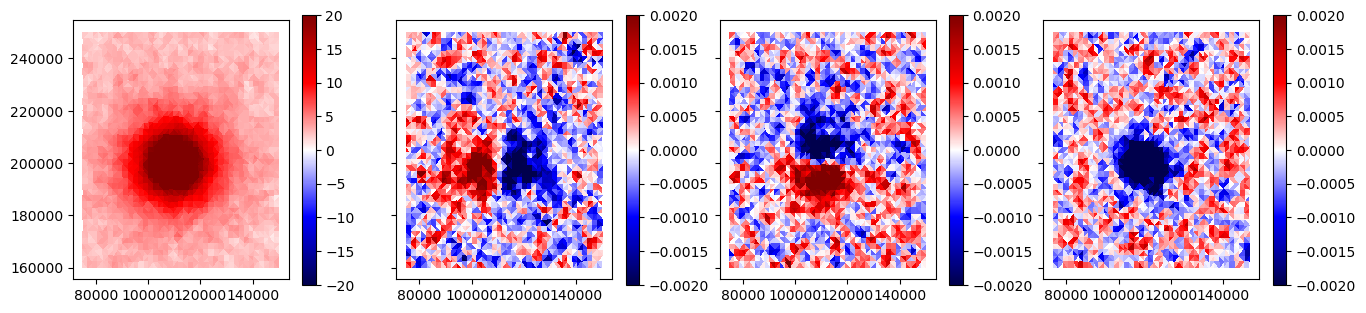

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, field, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

## Calculate the matrices involved

In [5]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [6]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [7]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [8]:
def gauss_newton_step(parameters, data, coordinates, data_observed, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    # Weights don't seem to make a difference
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    deltap = np.linalg.solve(
        ATQ @ A,
        -ATQ @ (f + Br)
    )
    deltad = r - BTQ @ Br - BTQ @ (f + A @ deltap)
    return deltap, deltad

In [9]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, maxit=50, tol=1e-2):
    """
    """
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    region = vd.get_region(coordinates)
    mean_height = np.mean(coordinates[2])
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        mean_height - np.abs(0.1 * mean_height),
        0,
    ])
    data = 0.99 * np.copy(data_observed)    
    euler = eulers_equation(*coordinates, data, parameters, structural_index)
    euler_misfit = np.sum(np.abs(euler))
    misfit = np.linalg.norm(data_observed - data)
    merit = misfit**2 + np.sum(np.abs(euler))
    print(f"000 | Euler: {euler_misfit:.3e} | misfit: {misfit:.3e} | merit: {merit:.3e}")    
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters,
            data, 
            coordinates, 
            data_observed, 
            structural_index,
        )
        parameters += deltap
        data += deltad
        euler = eulers_equation(*coordinates, data, parameters, structural_index)
        misfit = np.linalg.norm(data_observed - data)
        euler_misfit = np.sum(np.abs(euler))
        new_merit = misfit**2 + euler_misfit
        if new_merit > merit:
            print("Increase")
            break
        merit_change = abs((merit - new_merit) / merit)
        merit = new_merit
        print(f"{i + 1:03d} | Euler: {euler_misfit:.3e} | misfit: {misfit:.3e} | merit: {merit:.3e}")
        if merit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [10]:
def euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    A = np.stack([xderiv, yderiv, zderiv, np.full_like(field, structural_index)], axis=1)
    d = x * xderiv + y * yderiv + z * zderiv + structural_index * field
    parameters = np.linalg.solve(A.T @ A, A.T @ d)
    return parameters

In [11]:
%%time
structural_index = 2
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 4.424e+04 | misfit: 3.382e+00 | merit: 4.425e+04
001 | Euler: 5.813e+03 | misfit: 4.912e-02 | merit: 5.813e+03
002 | Euler: 9.983e+02 | misfit: 4.020e-02 | merit: 9.983e+02
003 | Euler: 4.001e+02 | misfit: 4.054e-02 | merit: 4.001e+02
004 | Euler: 2.062e+01 | misfit: 4.057e-02 | merit: 2.062e+01
Increase

         True: 110000.0 200000.0 -10000.0 2.0
    Inversion: 110925.2 199363.4 -10024.9 1.9
Devoncolution: 113698.8 203891.5 -2163.3 2.5

CPU times: user 1.59 s, sys: 4.2 ms, total: 1.59 s
Wall time: 1.59 s


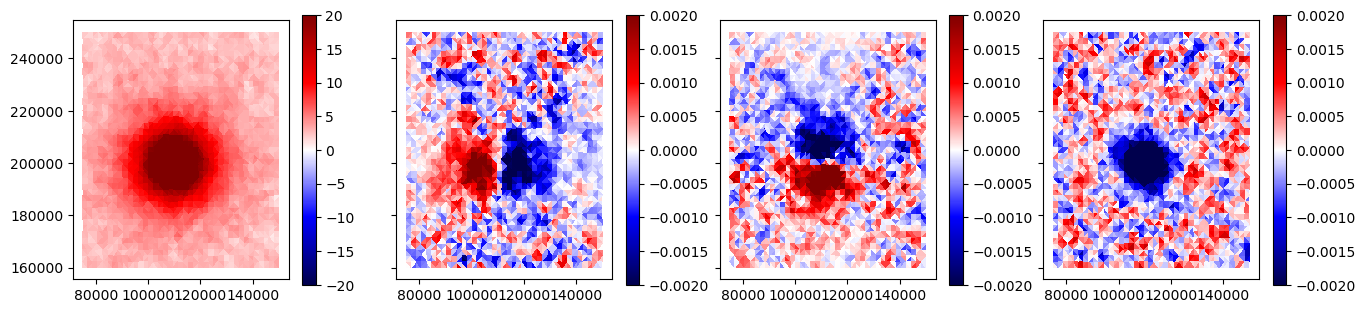

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, d, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

In [13]:
structural_index = 1
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 4.231e+04 | misfit: 3.382e+00 | merit: 4.232e+04
001 | Euler: 3.968e+03 | misfit: 4.398e-02 | merit: 3.968e+03
002 | Euler: 2.632e+02 | misfit: 4.095e-02 | merit: 2.632e+02
003 | Euler: 1.331e+02 | misfit: 4.101e-02 | merit: 1.331e+02
004 | Euler: 9.365e+00 | misfit: 4.104e-02 | merit: 9.367e+00
Increase

         True: 110000.0 200000.0 -10000.0 2.0
    Inversion: 111298.2 200021.1 -4439.8 -4.3
Devoncolution: 113677.5 203849.8 591.8 -0.5



In [14]:
structural_index = 3
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 4.827e+04 | misfit: 3.382e+00 | merit: 4.828e+04
001 | Euler: 8.306e+03 | misfit: 5.733e-02 | merit: 8.306e+03
002 | Euler: 2.268e+03 | misfit: 4.031e-02 | merit: 2.268e+03
003 | Euler: 8.723e+02 | misfit: 4.094e-02 | merit: 8.723e+02
004 | Euler: 8.380e+01 | misfit: 4.083e-02 | merit: 8.380e+01
005 | Euler: 5.806e+01 | misfit: 4.070e-02 | merit: 5.806e+01
006 | Euler: 1.355e+01 | misfit: 4.068e-02 | merit: 1.355e+01
007 | Euler: 1.096e+01 | misfit: 4.067e-02 | merit: 1.096e+01
008 | Euler: 4.172e+00 | misfit: 4.067e-02 | merit: 4.174e+00
009 | Euler: 2.853e+00 | misfit: 4.067e-02 | merit: 2.855e+00
010 | Euler: 1.228e+00 | misfit: 4.067e-02 | merit: 1.229e+00
011 | Euler: 7.885e-01 | misfit: 4.067e-02 | merit: 7.901e-01
012 | Euler: 3.504e-01 | misfit: 4.067e-02 | merit: 3.520e-01
013 | Euler: 2.198e-01 | misfit: 4.067e-02 | merit: 2.214e-01
014 | Euler: 9.903e-02 | misfit: 4.067e-02 | merit: 1.007e-01
015 | Euler: 6.143e-02 | misfit: 4.067e-02 | merit: 6.308e-02
016 | Eu